In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install mlrose-hiive

     |████████████████████████████████| 49 kB 2.6 MB/s 
  Created wheel for mlrose-hiive: filename=mlrose_hiive-2.2.4-py3-none-any.whl size=98351 sha256=81ab019d4e01c63ebba5a94f98ec4671218c42e8520c73aeb721b7182cc8a2c9
  Stored in directory: /root/.cache/pip/wheels/ca/9c/44/36113054dda94da67040173c2a475dbfb6980c2c6ddf5747b1
Successfully built mlrose-hiive


In [4]:
import sklearn
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=[10,5])
import mlrose_hiive
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,auc,make_scorer,recall_score,roc_auc_score,precision_score, balanced_accuracy_score
from functools import partial
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, learning_curve, cross_val_score, validation_curve
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [5]:
%cd /content/drive/My Drive/Colab Notebooks/
phishing = pd.read_csv("Phishing.csv")

/content/drive/My Drive/Colab Notebooks


In [6]:
phishing.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,1,0,0,1,-1,-1,-1,0,0,0,1,1,-1,1,-1,1,1,0,0,0,0,0,-1,1,-1,-1,0,1,1,1
1,0,1,0,0,0,-1,0,1,0,0,0,1,1,0,-1,-1,0,0,0,0,0,0,0,-1,1,0,-1,0,1,0,1
2,0,0,0,0,0,-1,-1,-1,0,0,0,1,1,0,-1,-1,1,1,0,0,0,0,0,0,1,1,-1,0,0,1,1
3,0,0,0,0,0,-1,-1,-1,1,0,0,1,-1,0,0,-1,0,0,0,0,0,0,0,-1,1,1,-1,0,-1,0,1
4,0,0,1,0,0,-1,1,1,0,0,0,0,1,0,0,-1,0,0,0,1,0,1,0,-1,1,0,-1,0,1,0,-1


In [7]:
features = [col for col in phishing.columns if col not in ['Result']]
print(len(features))

30


# Pre-processing data the same way as last assignment

In [8]:
count_n1, count_1 = phishing['Result'].value_counts()
#print(count_n1, count_1)
# divide by class
class_n1 = phishing[phishing['Result'] == -1]
class_1 = phishing[phishing['Result'] == 1]

In [9]:
class_1_over = class_1.sample(count_n1, replace=True, random_state = 7)
#class_0_over = class_0.sample(count_n1, replace=True)

data_over = pd.concat([class_n1, class_1_over], axis=0)
#test_0_over = pd.concat([class_n1, class_0_over], axis=0)

print('Random over-sampling:')
print(data_over.Result.value_counts())

Random over-sampling:
 1    1362
-1    1362
Name: Result, dtype: int64


In [10]:
# I have 2106 datapoints with 9 features
# divide the dataset into training set and testing set using SciKit-Learn

X = data_over.drop('Result', axis=1)
y = data_over['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [11]:
# scale the dataset before training 

scaler = StandardScaler()
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Build plotting function

In [12]:
def plot_learning_curve(classifier, title, data_X, data_y, cv, n_jobs):
    
    train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title(title)
    plt.xlabel("Training sizes")
    plt.ylabel("score")
    #plt.ylim(ylim)
    #lw = 2
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    #plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
    #             train_scores_mean + train_scores_std, alpha=0.2,
    #             color="darkorange", lw=lw)
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
    #plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
    #             test_scores_mean + test_scores_std, alpha=0.2,
    #             color="navy", lw=lw)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Recall the best model from Assignment1

In [ ]:
# best model in assignment 1
NN_classifier_4 = MLPClassifier(activation='tanh', hidden_layer_sizes = (110,), 
                                learning_rate_init = 0.1, max_iter = 500,
                                random_state=7)
NN_classifier_4.fit(X_train,y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(110,), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=7, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
print('Cross Validation Score:'
     )
CVscores_train = cross_val_score(NN_classifier_4, X_train, y_train,
                         scoring="f1_macro", cv=10)
print(CVscores_train,"\n", "ave_f1_cv:", CVscores_train.mean(), '\n')

print("Training precision_CV")
scorer = make_scorer(precision_score)
CVscores_train = cross_val_score(NN_classifier_4, X_train, y_train,
                         scoring=scorer, cv=10)
print(CVscores_train,"\n", "ave_precision_cv:", CVscores_train.mean(), '\n')

#testing accuracy & f1 & balanced accuracy & recall & precision
NN_test_predict_4 = NN_classifier_4.predict(X_test)
accuracy_test_predict = accuracy_score(y_test, NN_test_predict_4)
f1_test_predict = f1_score(y_test, NN_test_predict_4,average='macro')
baccu_test_predict = balanced_accuracy_score(y_test, NN_test_predict_4)
recall_test_predict = recall_score(y_test, NN_test_predict_4)
precision_test_predict = precision_score(y_test, NN_test_predict_4)

print(
      'Testing set','\n'
      'testing accuracy', accuracy_test_predict, '\n'
      'testing f1',  f1_test_predict,'\n'
     'balanced accuracy', baccu_test_predict,'\n'
     'recall score', recall_test_predict,'\n'
     'precision score', precision_test_predict)

Cross Validation Score:
[0.96788383 0.97706374 0.97705215 0.9816452  0.95412458 0.9724562
 0.96788383 0.97247475 0.98623129 0.95852535] 
 ave_f1_cv: 0.971534089570586 

Training precision_CV
[0.95535714 0.98165138 0.96460177 0.97321429 0.95454545 0.95614035
 0.96396396 0.97272727 0.97345133 0.96296296] 
 ave_precision_cv: 0.9658615907140199 

Testing set 
testing accuracy 0.9522935779816514 
testing f1 0.9521762021762021 
balanced accuracy 0.951674215464251 
recall score 0.9318181818181818 
precision score 0.968503937007874


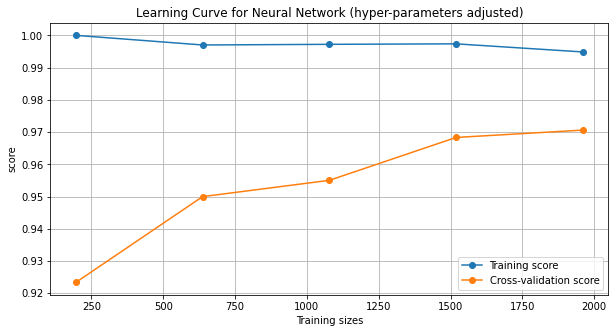

In [ ]:
#Accuracy
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(estimator=NN_classifier_4, X=X_train, y=y_train, 
                                              train_sizes = train_sizes, cv=10, n_jobs=-1)
plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning Curve for Neural Network (hyper-parameters adjusted)')
plt.xlabel('Training sizes')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [14]:
sa_nn_baseline = mlrose_hiive.NeuralNetwork(hidden_nodes=(110,), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 500,
                            learning_rate = 0.1,
                           curve = True, random_state=7)

In [15]:
sa_nn_baseline.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(110,), is_classifier=True, learning_rate=0.1,
              max_attempts=10, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
pred_y = sa_nn_baseline.predict(X_test)
sa_accuracy = accuracy_score(y_test, pred_y)
pred_y_train = sa_nn_baseline.predict(X_train)
sa_accuracy_train = accuracy_score(y_train, pred_y_train)
scores = cross_val_score(sa_nn_baseline, X_train, y_train, cv=5)
print(f'Accuracy Scores. Train: {sa_accuracy_train}')

Accuracy Scores. Train: 0.1179440110142267


In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline, 
                                 X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')


[0.13761468 0.10321101 0.09633028 0.12844037 0.12413793] 
 ave_cv: 0.11794685226194243 



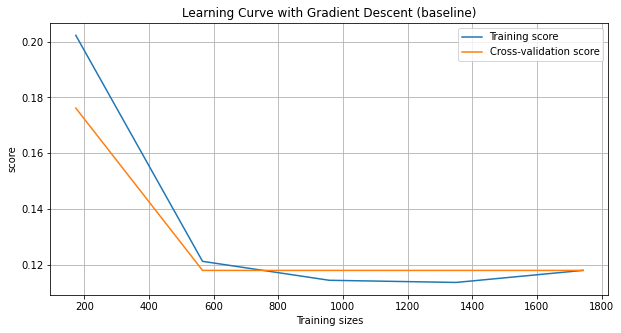

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
sa_nn_baseline1 = mlrose_hiive.NeuralNetwork(hidden_nodes=(5,2,3), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 500,
                            learning_rate = 0.1,
                           curve = True, random_state=7)

In [ ]:
sa_nn_baseline1.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(5, 2, 3), is_classifier=True, learning_rate=0.1,
              max_attempts=10, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline1, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.30045872 0.28440367 0.31192661 0.30504587 0.33103448] 
 ave_cv: 0.30657386902878836 



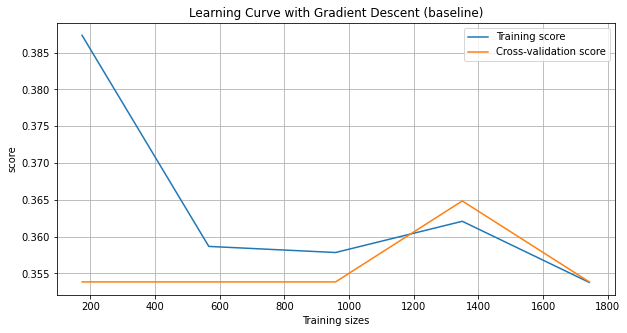

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline1, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
sa_nn_baseline2 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 500,
                            learning_rate = 0.1,
                           curve = True, random_state=7)

In [ ]:
sa_nn_baseline2.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.1,
              max_attempts=10, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline2, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.35779817 0.37844037 0.34862385 0.33715596 0.34712644] 
 ave_cv: 0.3538289570810925 



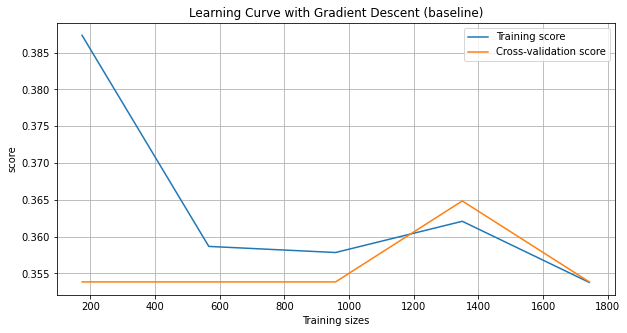

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline2, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
sa_nn_baseline3 = mlrose_hiive.NeuralNetwork(hidden_nodes=(20,20,20), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 500,
                            learning_rate = 0.1,
                           curve = True, random_state=7)

In [ ]:
sa_nn_baseline3.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(20, 20, 20), is_classifier=True, learning_rate=0.1,
              max_attempts=10, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline3, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.31192661 0.32110092 0.26605505 0.33027523 0.25517241] 
 ave_cv: 0.2969060423916482 



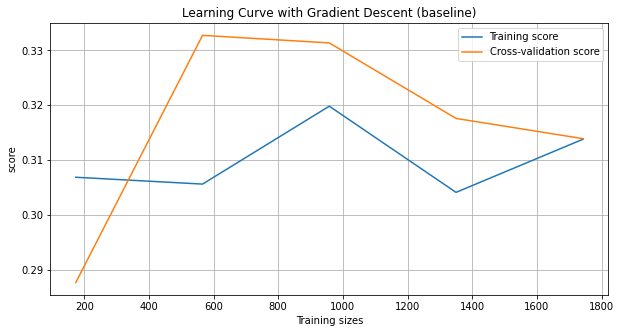

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline3, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
sa_nn_baseline4 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,5,2), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 500,
                            learning_rate = 0.1,
                           curve = True, random_state=7)

In [ ]:
sa_nn_baseline4.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(10, 5, 2), is_classifier=True, learning_rate=0.1,
              max_attempts=10, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline4, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.41513761 0.41513761 0.28440367 0.41055046 0.37471264] 
 ave_cv: 0.37998840029526526 



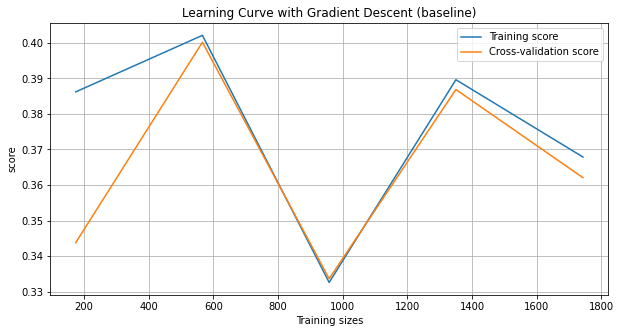

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline4, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
sa_nn_baseline5 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,2), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 500,
                            learning_rate = 0.1,
                           curve = True, random_state=7)

In [ ]:
sa_nn_baseline5.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(10, 2), is_classifier=True, learning_rate=0.1,
              max_attempts=10, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline5, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.19036697 0.18119266 0.1766055  0.19724771 0.1908046 ] 
 ave_cv: 0.18724348834756935 



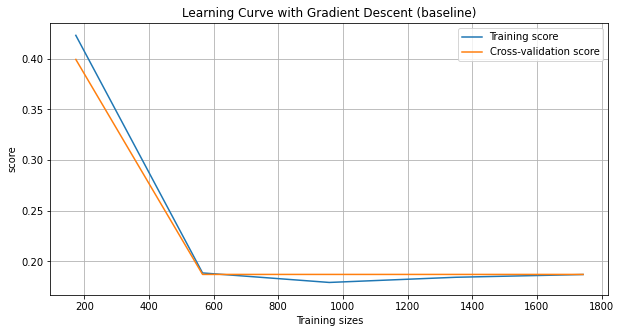

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline5, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
sa_nn_baseline6 = mlrose_hiive.NeuralNetwork(hidden_nodes=(110,), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 500,
                            learning_rate = 0.001,
                           curve = True, random_state=7)

In [ ]:
sa_nn_baseline6.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(110,), is_classifier=True, learning_rate=0.001,
              max_attempts=10, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline6, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.42201835 0.43348624 0.43807339 0.44724771 0.44137931] 
 ave_cv: 0.43644099968364447 



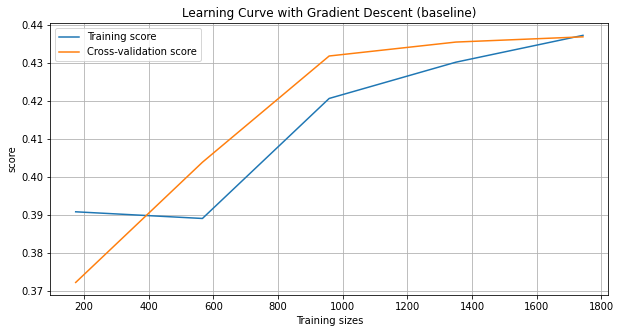

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline6, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
sa_nn_baseline7 = mlrose_hiive.NeuralNetwork(hidden_nodes=(110,), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 5000,
                            learning_rate = 0.001,
                           curve = True, random_state=7)

In [ ]:
sa_nn_baseline7.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(110,), is_classifier=True, learning_rate=0.001,
              max_attempts=10, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline7, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.42201835 0.43348624 0.43807339 0.44724771 0.44137931] 
 ave_cv: 0.43644099968364447 



In [ ]:
sa_nn_baseline8 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,5,2), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 5000,
                            learning_rate = 0.001,
                           curve = True, random_state=7)

In [ ]:
sa_nn_baseline8.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(10, 5, 2), is_classifier=True, learning_rate=0.001,
              max_attempts=10, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline8, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.42431193 0.41743119 0.40825688 0.42201835 0.4183908 ] 
 ave_cv: 0.4180818306443109 



In [16]:
sa_nn_baseline9 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,5,5,2), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 10000,
                            learning_rate = 0.0001,
                           curve = True, random_state=7)

In [17]:
sa_nn_baseline9.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(10, 5, 5, 2), is_classifier=True,
              learning_rate=0.0001, max_attempts=10, max_iters=10000,
              mutation_prob=0.1, pop_size=200, random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline9, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.4266055  0.39220183 0.41284404 0.39908257 0.41149425] 
 ave_cv: 0.40844563956553837 



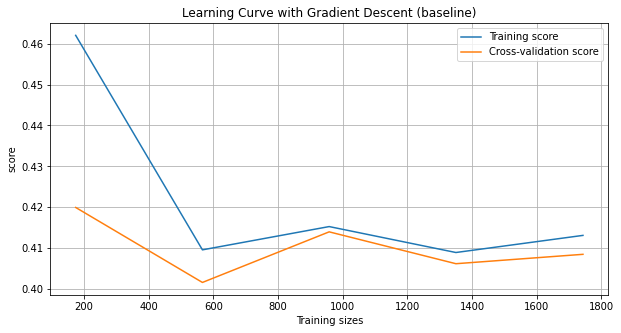

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline9, title, X_train, y_train, cv=None, n_jobs=-1)

In [18]:
sa_nn_baseline10 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,5,2), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           #is_classifier = True, early_stopping = True,
                            max_iters = 10000,
                            learning_rate = 0.0001,
                           curve = True, random_state=7)

In [19]:
sa_nn_baseline10.fit(X_train,y_train)

NeuralNetwork(activation='tanh', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(10, 5, 2), is_classifier=True, learning_rate=0.0001,
              max_attempts=10, max_iters=10000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn_baseline10, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.42201835 0.4059633  0.41743119 0.41743119 0.4183908 ] 
 ave_cv: 0.4162469682589898 



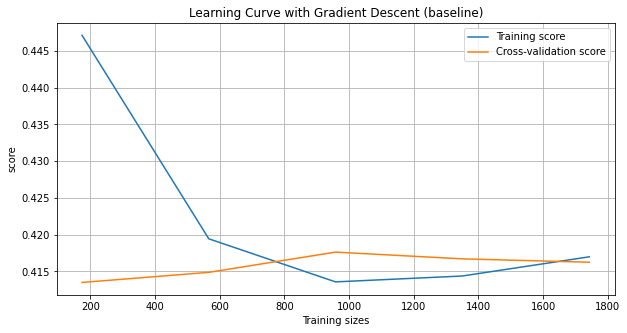

In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline10, title, X_train, y_train, cv=None, n_jobs=-1)

In [12]:
sa_nn_baseline11 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,), activation='sigmoid',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           is_classifier = True, early_stopping = True,
                            max_iters = 1000,
                            learning_rate = 0.01,
                           curve = True, random_state=7)

In [13]:
sa_nn_baseline11.fit(X_train,y_train)

NeuralNetwork(activation='sigmoid', algorithm='gradient_descent', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10,), is_classifier=True, learning_rate=0.01,
              max_attempts=10, max_iters=1000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [14]:
CVscores_train = cross_val_score(sa_nn_baseline11, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.49082569 0.5        0.49770642 0.49770642 0.49655172] 
 ave_cv: 0.49655805124960456 



In [16]:
sa_nn_baseline12 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,), activation='tanh',
                           algorithm = 'gradient_descent',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           is_classifier = True, early_stopping = True,
                            max_iters = 1000,
                            learning_rate = 0.01,
                           curve = True, random_state=7)

In [19]:
sa_nn_baseline12.fit(X_train,y_train)
CVscores_train = cross_val_score(sa_nn_baseline12, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.30045872 0.30045872 0.31192661 0.32568807 0.33333333] 
 ave_cv: 0.31437308868501523 



In [20]:
sa_nn_baseline13 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='sigmoid',
                           algorithm = 'gradient_descent',
                           schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           is_classifier = True, early_stopping = True,
                            max_iters = 1000000,
                            learning_rate = 0.001,
                           curve = True, random_state=7)
sa_nn_baseline13.fit(X_train,y_train)
CVscores_train = cross_val_score(sa_nn_baseline13, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.50229358 0.50458716 0.50458716 0.50458716 0.50344828] 
 ave_cv: 0.5039006643467256 



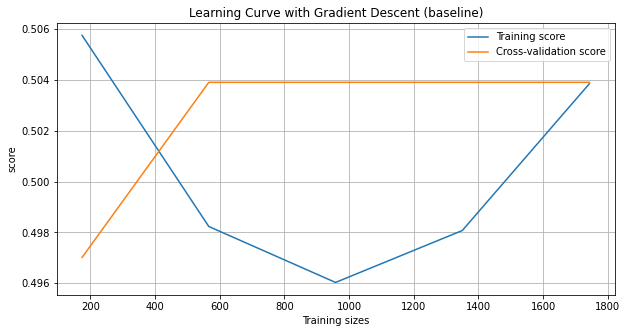

In [68]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline13, title, X_train, y_train, cv=None, n_jobs=-1)

In [13]:
sa_nn_baseline14 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10), activation='sigmoid',
                           algorithm = 'gradient_descent',
                           schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           is_classifier = True, early_stopping = True,
                            max_iters = 1000000,
                            learning_rate = 0.001,
                           curve = True, random_state=7)
sa_nn_baseline14.fit(X_train,y_train)
CVscores_train = cross_val_score(sa_nn_baseline14, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.50229358 0.50458716 0.50458716 0.50458716 0.50344828] 
 ave_cv: 0.5039006643467256 



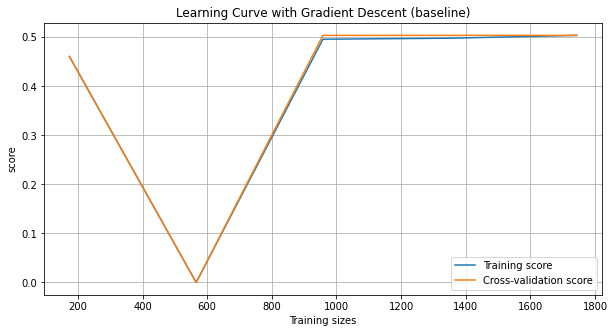

In [70]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline14, title, X_train, y_train, cv=None, n_jobs=-1)

In [100]:
sa_nn_baseline15 = mlrose_hiive.NeuralNetwork(hidden_nodes=(110,10), activation='sigmoid',
                           algorithm = 'gradient_descent',
                           schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           is_classifier = True, early_stopping = True,
                            max_iters = 1000000,
                            learning_rate = 0.001,
                           curve = True, random_state=7)
sa_nn_baseline15.fit(X_train,y_train)
CVscores_train = cross_val_score(sa_nn_baseline15, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.33486239 0.34174312 0.31422018 0.34174312 0.34482759] 
 ave_cv: 0.33547927870926925 



In [ ]:
title = "Learning Curve with Gradient Descent (baseline)"
plot_learning_curve(sa_nn_baseline15, title, X_train, y_train, cv=None, n_jobs=-1)

# Build models with RO algorithms

## Random Hill Climbing

In [ ]:
rhc_nn1 = mlrose_hiive.NeuralNetwork(hidden_nodes=[110], activation='tanh',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 500,
                           bias = True, learning_rate = 0.1,
                           restarts=5, curve = True, random_state=7)

In [ ]:
rhc_nn1.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='random_hill_climb', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=[110], is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=5,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(rhc_nn1, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.15137615 0.11697248 0.12614679 0.14449541 0.14252874] 
 ave_cv: 0.13630391226405145 



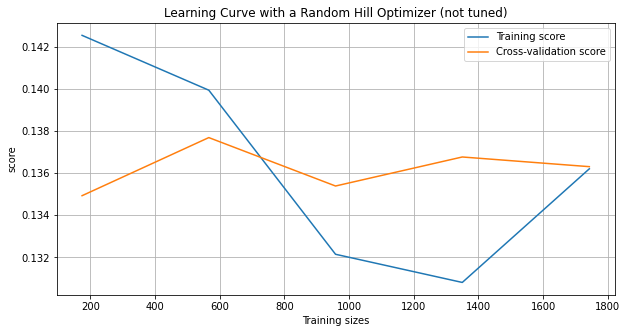

In [ ]:
title = "Learning Curve with a Random Hill Optimizer (not tuned)"
plot_learning_curve(rhc_nn1, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
rhc_nn2 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 500,
                           bias = True, learning_rate = 0.1,
                           restarts=5, curve = True, random_state=7)

In [ ]:
rhc_nn2.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='random_hill_climb', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=5,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(rhc_nn2, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.40825688 0.39449541 0.39449541 0.39220183 0.39310345] 
 ave_cv: 0.3965105979120532 



In [ ]:
rhc_nn3 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 500,
                           bias = True, learning_rate = 0.01,
                           restarts=5, curve = True, random_state=7)

In [ ]:
rhc_nn3.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='random_hill_climb', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.01,
              max_attempts=200, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=5,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(rhc_nn3, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.37155963 0.38073394 0.35550459 0.35091743 0.35172414] 
 ave_cv: 0.3620879468522619 



In [ ]:
rhc_nn4 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 300, max_iters = 600,
                           bias = True, learning_rate = 0.01,
                           restarts=5, curve = True, random_state=7)

In [ ]:
rhc_nn4.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='random_hill_climb', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.01,
              max_attempts=300, max_iters=600, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=5,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(rhc_nn4, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.36926606 0.37614679 0.35091743 0.34633028 0.34712644] 
 ave_cv: 0.35795739744806493 



In [14]:
rhc_nn5 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 300, max_iters = 5000,
                           bias = True, learning_rate = 0.1,
                           restarts=5, curve = True, random_state=7)

In [15]:
rhc_nn5.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='random_hill_climb', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.1,
              max_attempts=300, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=5,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(rhc_nn5, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.49082569 0.48165138 0.49311927 0.47706422 0.47816092] 
 ave_cv: 0.4841642939997891 



In [28]:
rhc_nn5a = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='sigmoid',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 300, max_iters = 5000,
                           bias = True, learning_rate = 0.1,
                           restarts=5, curve = True, random_state=7)
rhc_nn5a.fit(X_train, y_train)
CVscores_train = cross_val_score(rhc_nn5a, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.4587156  0.46788991 0.46330275 0.45183486 0.45977011] 
 ave_cv: 0.46030264684171673 



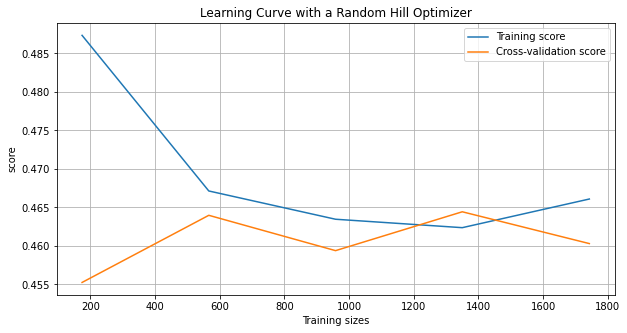

In [29]:
title = "Learning Curve with a Random Hill Optimizer"
plot_learning_curve(rhc_nn5a, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
rhc_nn6 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,5,2), activation='tanh',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 300, max_iters = 5000,
                           bias = True, learning_rate = 0.1,
                           restarts=5, curve = True, random_state=7)

In [ ]:
rhc_nn6.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='random_hill_climb', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 5, 2), is_classifier=True, learning_rate=0.1,
              max_attempts=300, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=5,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(rhc_nn6, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.48165138 0.49311927 0.49311927 0.48853211 0.48505747] 
 ave_cv: 0.4882958979225983 



In [ ]:
# case 7
rhc_nn7 = mlrose_hiive.NeuralNetwork(hidden_nodes=(110,), activation='tanh',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 500,
                           bias = True, learning_rate = 0.1,
                           curve = True, random_state=7)

In [ ]:
rhc_nn7.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='random_hill_climb', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(110,), is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(rhc_nn7, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.1559633  0.11926606 0.11926606 0.14678899 0.14252874] 
 ave_cv: 0.13676262786038176 



In [ ]:
# case 8
rhc_nn8 = mlrose_hiive.NeuralNetwork(hidden_nodes=(110,), activation='tanh',
                           algorithm = 'random_hill_climb',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           bias = True, learning_rate = 0.1,
                           curve = True, random_state=7)

In [ ]:
rhc_nn8.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='random_hill_climb', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(110,), is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(rhc_nn8, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.44266055 0.42889908 0.44724771 0.44724771 0.45287356] 
 ave_cv: 0.4437857218179901 



### Conclusion: best model is 5 with cv accuracy score of 0.48

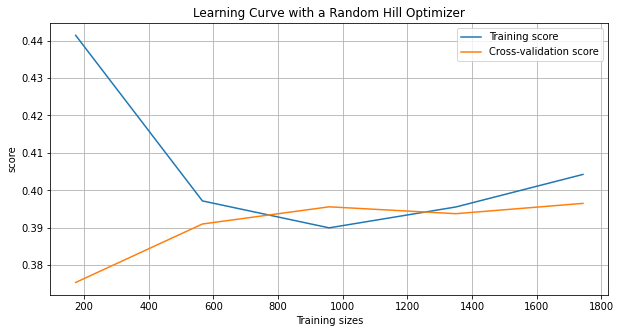

In [ ]:
title = "Learning Curve with a Random Hill Optimizer"
plot_learning_curve(rhc_nn2, title, X_train, y_train, cv=None, n_jobs=-1)

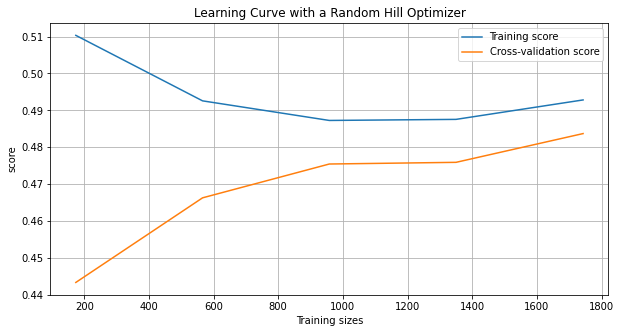

In [ ]:
title = "Learning Curve with a Random Hill Optimizer"
plot_learning_curve(rhc_nn5, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
rhc_nn5.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
y_pred = rhc_nn5.predict(X_test)
print(classification_report(pd.get_dummies(y_test.values.ravel()).values, y_pred))
y_pred_train = rhc_nn5.predict(X_train)
print(classification_report(pd.get_dummies(y_train.values.ravel()).values, y_pred_train))

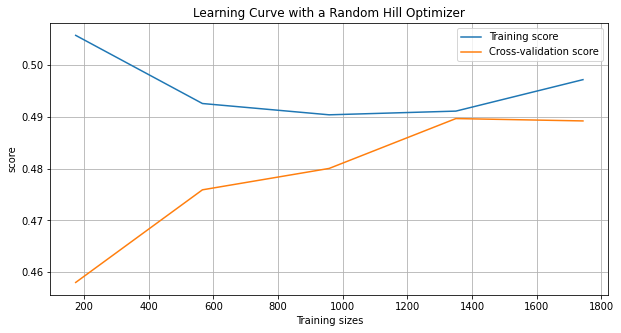

In [ ]:
title = "Learning Curve with a Random Hill Optimizer"
plot_learning_curve(rhc_nn6, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
rhc_nn6.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
y_pred = rhc_nn6.predict(X_test)
print(classification_report(pd.get_dummies(y_test.values.ravel()).values, y_pred))
y_pred_train = rhc_nn6.predict(X_train)
print(classification_report(pd.get_dummies(y_train.values.ravel()).values, y_pred_train))

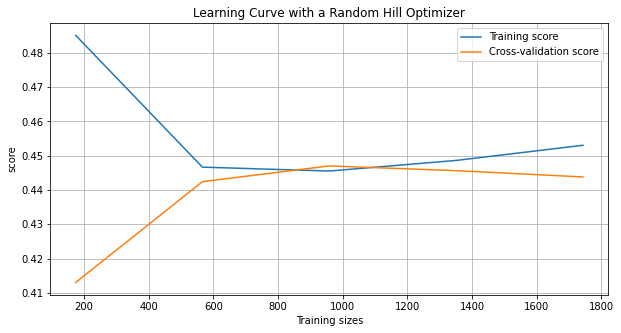

In [ ]:
title = "Learning Curve with a Random Hill Optimizer"
plot_learning_curve(rhc_nn8, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
rhc_nn8.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
y_pred = rhc_nn8.predict(X_test)
print(classification_report(pd.get_dummies(y_test.values.ravel()).values, y_pred))
y_pred_train = rhc_nn8.predict(X_train)
print(classification_report(pd.get_dummies(y_train.values.ravel()).values, y_pred_train))

## Simulated Annealing

In [ ]:
# case0
sa_nn0 = mlrose_hiive.NeuralNetwork(hidden_nodes=[110], activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 500,
                           bias = True, learning_rate = 0.1,
                           curve = True, random_state=7)

In [ ]:
sa_nn0.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=[110], is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn0, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.12385321 0.10550459 0.1146789  0.13761468 0.13103448] 
 ave_cv: 0.12253717178108195 



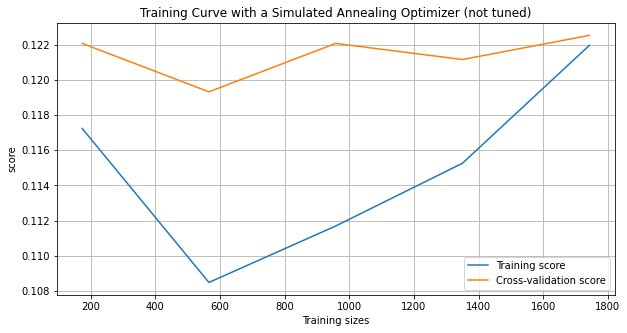

In [ ]:
title = "Training Curve with a Simulated Annealing Optimizer (not tuned)"
plot_learning_curve(sa_nn0, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
# case1
sa_nn = mlrose_hiive.NeuralNetwork(hidden_nodes=[110], activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           bias = True, learning_rate = .5,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=[110], is_classifier=True, learning_rate=0.5,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
pred_y = sa_nn.predict(X_test)
sa_accuracy = accuracy_score(y_test, pred_y)
pred_y_train = sa_nn.predict(X_train)
sa_accuracy_train = accuracy_score(y_train, pred_y_train)
scores = cross_val_score(sa_nn, X_train, y_train, cv=5)
print(f'Accuracy Scores. Train: {sa_accuracy_train}')

Accuracy Scores. Train: 0.48416704910509406


In [ ]:
# case 2
sa_nn2 = mlrose_hiive.NeuralNetwork(hidden_nodes=[110], activation='tanh',
                           algorithm = 'simulated_annealing',
                           schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           is_classifier = True, early_stopping = True,
                           max_attempts = 1000, max_iters = 4000,
                           bias = True, learning_rate = 0.1,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn2.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=[110], is_classifier=True, learning_rate=0.1,
              max_attempts=1000, max_iters=4000, mutation_prob=0.1,
              pop_size=200, random_state=7, restarts=0,
              schedule=ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001))

In [ ]:
pred_y = sa_nn2.predict(X_test)
sa_accuracy = accuracy_score(y_test, pred_y)
pred_y_train = sa_nn2.predict(X_train)
sa_accuracy_train = accuracy_score(y_train, pred_y_train)
scores = cross_val_score(sa_nn2, X_train, y_train, cv=5)
print(f'Accuracy Scores. Train: {sa_accuracy_train}')

Accuracy Scores. Train: 0.3708122992198256


In [ ]:
# case3
sa_nn3 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation = 'tanh',
                                          algorithm='simulated_annealing', 
                                          #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                                          is_classifier = True, early_stopping = True,
                                          max_attempts = 200, max_iters = 500,
                                          bias = True, learning_rate = 0.1,
                                          restarts=5, curve = True, random_state=7)


In [ ]:
sa_nn3.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=5,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn3, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.34633028 0.36238532 0.32568807 0.3646789  0.35632184] 
 ave_cv: 0.3510808815775598 



In [ ]:
# case4
sa_nn4 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           bias = True, learning_rate = .5,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn4.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.5,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn4, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.4793578  0.47477064 0.48623853 0.47477064 0.48045977] 
 ave_cv: 0.47911947695876833 



In [ ]:
# case5
sa_nn5 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'simulated_annealing',
                           schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           bias = True, learning_rate = .5,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn5.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.5,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn5, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.46559633 0.48853211 0.48165138 0.47477064 0.46896552] 
 ave_cv: 0.4759031951913951 



In [ ]:
# case6
sa_nn6 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'simulated_annealing',
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.5, min_temp=0.1),
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           bias = True, learning_rate = .1,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn6.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn6, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.44495413 0.44495413 0.47247706 0.47247706 0.46896552] 
 ave_cv: 0.460765580512496 



In [ ]:
# case7
sa_nn7 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,5,2), activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.01),
                           bias = True, learning_rate = .5,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn7.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 5, 2), is_classifier=True, learning_rate=0.5,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.01))

In [ ]:
CVscores_train = cross_val_score(sa_nn7, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.4266055  0.43577982 0.41743119 0.40366972 0.36551724] 
 ave_cv: 0.4098006959822841 



In [ ]:
# case8
sa_nn8 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,5,2), activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.01),
                           bias = True, learning_rate = .5, #clip_max = ,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn8.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 5, 2), is_classifier=True, learning_rate=0.5,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn8, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.49082569 0.48165138 0.48394495 0.46100917 0.47126437] 
 ave_cv: 0.47773911209532843 



In [16]:
# case9
sa_nn9 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.01),
                           bias = True, learning_rate = .5, clip_max = 5,
                           restarts=0, curve = True, random_state=7)

In [17]:
sa_nn9.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=5, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.5,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn9, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.4793578  0.47477064 0.48623853 0.47477064 0.48965517] 
 ave_cv: 0.4809585574185384 



In [30]:
sa_nn9a = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='sigmoid',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.01),
                           bias = True, learning_rate = .5, clip_max = 5,
                           restarts=0, curve = True, random_state=7)
sa_nn9a.fit(X_train, y_train)
CVscores_train = cross_val_score(sa_nn9a, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.48394495 0.4793578  0.47706422 0.46100917 0.47126437] 
 ave_cv: 0.47452810292101655 



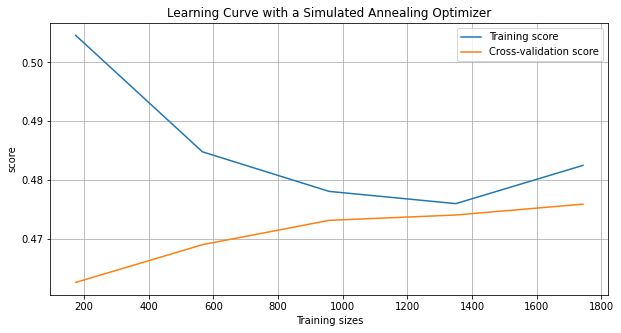

In [31]:
title = "Learning Curve with a Simulated Annealing Optimizer"
plot_learning_curve(sa_nn9a, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
# case10
sa_nn10 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 10000,
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.01),
                           bias = True, learning_rate = .5, clip_max = 5,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn10.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=5, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.5,
              max_attempts=200, max_iters=10000, mutation_prob=0.1,
              pop_size=200, random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn10, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.48394495 0.49311927 0.49082569 0.4793578  0.46896552] 
 ave_cv: 0.4832426447326795 



In [ ]:
# case11
sa_nn11 = mlrose_hiive.NeuralNetwork(hidden_nodes=(10,10,10), activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           #schedule = mlrose_hiive.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.01),
                           bias = True, learning_rate = .5, clip_max = 1,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn11.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=1, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.5,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn11, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.48394495 0.48165138 0.46788991 0.48394495 0.48735632] 
 ave_cv: 0.4809575028999262 



In [ ]:
# case12
sa_nn12 = mlrose_hiive.NeuralNetwork(hidden_nodes=[110], activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 500,
                           bias = True, learning_rate = .1,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn12.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=[110], is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn12, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.12385321 0.10550459 0.1146789  0.13761468 0.13103448] 
 ave_cv: 0.12253717178108195 



In [ ]:
# case13
sa_nn13 = mlrose_hiive.NeuralNetwork(hidden_nodes=[110], activation='tanh',
                           algorithm = 'simulated_annealing',
                           is_classifier = True, early_stopping = True,
                           max_attempts = 200, max_iters = 5000,
                           bias = True, learning_rate = .1,
                           restarts=0, curve = True, random_state=7)

In [ ]:
sa_nn13.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='simulated_annealing', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=[110], is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(sa_nn13, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.38073394 0.36009174 0.38073394 0.41513761 0.42298851] 
 ave_cv: 0.3919371506907098 



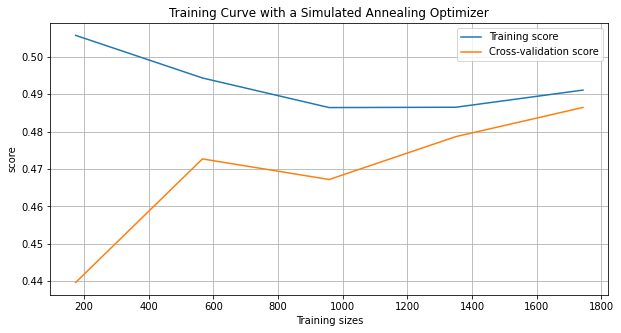

In [ ]:
title = "Training Curve with a Simulated Annealing Optimizer"
plot_learning_curve(sa_nn10, title, X_train, y_train, cv=None, n_jobs=-1)

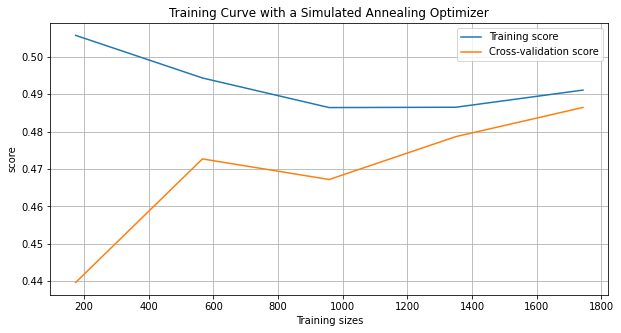

In [ ]:
title = "Training Curve with a Simulated Annealing Optimizer"
plot_learning_curve(sa_nn9, title, X_train, y_train, cv=None, n_jobs=-1)

In [ ]:
sa_nn9.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
y_pred = sa_nn9.predict(X_test)
print(classification_report(pd.get_dummies(y_test.values.ravel()).values, y_pred))
y_pred_train = sa_nn9.predict(X_train)
print(classification_report(pd.get_dummies(y_train.values.ravel()).values, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       281
           1       0.91      0.97      0.94       264

   micro avg       0.94      0.94      0.94       545
   macro avg       0.94      0.94      0.94       545
weighted avg       0.94      0.94      0.94       545
 samples avg       0.94      0.94      0.94       545

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1081
           1       0.95      0.97      0.96      1098

   micro avg       0.96      0.96      0.96      2179
   macro avg       0.96      0.96      0.96      2179
weighted avg       0.96      0.96      0.96      2179
 samples avg       0.96      0.96      0.96      2179



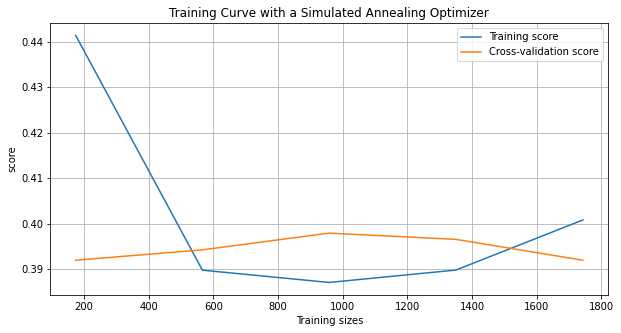

In [ ]:
title = "Training Curve with a Simulated Annealing Optimizer"
plot_learning_curve(sa_nn13, title, X_train, y_train, cv=None, n_jobs=-1)

# Genetic Algorithm

In [ ]:
# case0
ga_nn0 = mlrose_hiive.NeuralNetwork(hidden_nodes = (110,), activation = 'tanh',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 500,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1, curve = True,
                                 random_state = 7,)

In [ ]:
ga_nn0.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='genetic_alg', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=False,
              hidden_nodes=(110,), is_classifier=True, learning_rate=0.1,
              max_attempts=10, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(ga_nn0, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.45412844 0.46330275 0.46559633 0.42201835 0.43678161] 
 ave_cv: 0.4483654961510071 



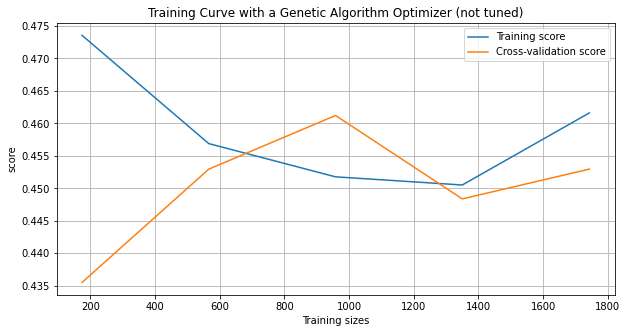

In [ ]:
title = "Training Curve with a Genetic Algorithm Optimizer (not tuned)"
plot_learning_curve(ga_nn0, title, X_train, y_train, cv=None, n_jobs=-1) 

In [ ]:
# case1
ga_nn1 = mlrose_hiive.NeuralNetwork(hidden_nodes = (110,), activation = 'tanh',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 500,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 7,
                                 pop_size=200,
                                 mutation_prob=0.1)

In [ ]:
ga_nn1.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='genetic_alg', bias=True,
              clip_max=10000000000.0, curve=False, early_stopping=True,
              hidden_nodes=(110,), is_classifier=True, learning_rate=0.1,
              max_attempts=100, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(ga_nn1, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.45412844 0.46559633 0.44266055 0.42201835 0.45057471] 
 ave_cv: 0.44699567647368976 



In [ ]:
# case2
ga_nn2 = mlrose_hiive.NeuralNetwork(hidden_nodes = (10,10,10), activation = 'tanh',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 500,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 random_state = 7,
                                 pop_size=200,
                                 mutation_prob=0.1)

In [ ]:
ga_nn2.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='genetic_alg', bias=True,
              clip_max=10000000000.0, curve=False, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.1,
              max_attempts=100, max_iters=500, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(ga_nn2, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.43119266 0.45642202 0.45642202 0.45642202 0.43678161] 
 ave_cv: 0.4474480649583465 



In [ ]:
# case3
ga_nn3 = mlrose_hiive.NeuralNetwork(hidden_nodes = (110,), activation = 'tanh',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 5000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 200,
                                 random_state = 7,
                                 pop_size=200,
                                 mutation_prob=0.1)

In [ ]:
ga_nn3.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='genetic_alg', bias=True,
              clip_max=10000000000.0, curve=False, early_stopping=True,
              hidden_nodes=(110,), is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(ga_nn3, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.46559633 0.4266055  0.43807339 0.42201835 0.45747126] 
 ave_cv: 0.44195296846989346 



In [18]:
# case4
ga_nn4 = mlrose_hiive.NeuralNetwork(hidden_nodes = (10,10,10), activation = 'tanh',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 5000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 200,
                                 random_state = 7,
                                 pop_size=200,
                                 mutation_prob=0.1, curve = True)

In [19]:
ga_nn4.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='genetic_alg', bias=True,
              clip_max=10000000000.0, curve=True, early_stopping=True,
              hidden_nodes=(10, 10, 10), is_classifier=True, learning_rate=0.1,
              max_attempts=200, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(ga_nn4, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.45642202 0.4587156  0.4587156  0.42431193 0.45747126] 
 ave_cv: 0.4511272803964991 



In [32]:
# case4
ga_nn4a = mlrose_hiive.NeuralNetwork(hidden_nodes = (10,10,10), activation = 'sigmoid',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 5000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 200,
                                 random_state = 7,
                                 pop_size=200,
                                 mutation_prob=0.1, curve = True)
ga_nn4a.fit(X_train, y_train)
CVscores_train = cross_val_score(ga_nn4a, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=5)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.         0.05733945 0.         0.         0.        ] 
 ave_cv: 0.011467889908256881 



In [33]:
title = "Learning Curve with a Genetic Algorithm Optimizer"
plot_learning_curve(ga_nn4a, title, X_train, y_train, cv=None, n_jobs=-1) 

KeyboardInterrupt: ignored

In [ ]:
ga_nn4.fit(X_train, pd.get_dummies(y_train.values.ravel()).values)
y_pred = ga_nn4.predict(X_test)
print(classification_report(pd.get_dummies(y_test.values.ravel()).values, y_pred))
y_pred_train = ga_nn4.predict(X_train)
print(classification_report(pd.get_dummies(y_train.values.ravel()).values, y_pred_train))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       281
           1       0.85      0.90      0.87       264

   micro avg       0.88      0.88      0.88       545
   macro avg       0.88      0.88      0.88       545
weighted avg       0.88      0.88      0.88       545
 samples avg       0.88      0.88      0.88       545

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1081
           1       0.89      0.93      0.91      1098

   micro avg       0.91      0.91      0.91      2179
   macro avg       0.91      0.91      0.91      2179
weighted avg       0.91      0.91      0.91      2179
 samples avg       0.91      0.91      0.91      2179



In [ ]:
# case5
ga_nn5 = mlrose_hiive.NeuralNetwork(hidden_nodes = (10,5,2), activation = 'tanh',
                                 algorithm = 'genetic_alg', 
                                 max_iters = 5000,
                                 bias = True, is_classifier = True, 
                                 learning_rate = 0.01,
                                 early_stopping = True,
                                 max_attempts = 200,
                                 random_state = 7,
                                 pop_size=500,
                                 mutation_prob=0.2)

In [ ]:
ga_nn5.fit(X_train, y_train)

NeuralNetwork(activation='tanh', algorithm='genetic_alg', bias=True,
              clip_max=10000000000.0, curve=False, early_stopping=True,
              hidden_nodes=(10, 5, 2), is_classifier=True, learning_rate=0.01,
              max_attempts=200, max_iters=5000, mutation_prob=0.2, pop_size=500,
              random_state=7, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [ ]:
CVscores_train = cross_val_score(ga_nn5, 
                                  X_train, y_train,
                                 #scoring="f1_macro", 
                                 cv=3)
print(CVscores_train,"\n", "ave_cv:", CVscores_train.mean(), '\n')

[0.45392022 0.43112948 0.44490358] 
 ave_cv: 0.44331775931125694 



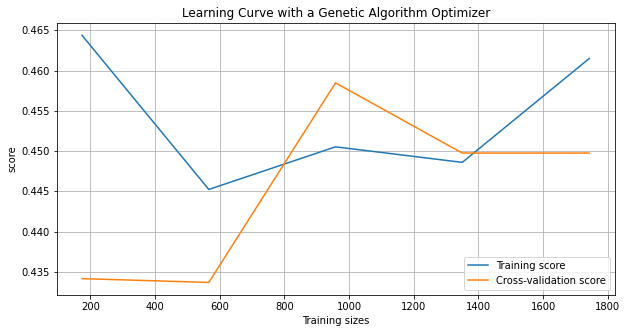

In [ ]:
title = "Learning Curve with a Genetic Algorithm Optimizer"
plot_learning_curve(ga_nn4, title, X_train, y_train, cv=None, n_jobs=-1) 

In [ ]:
title = "Learning Curve with a Genetic Algorithm Optimizer"
plot_learning_curve(ga_nn5, title, X_train, y_train, cv=None, n_jobs=-1) 

KeyboardInterrupt: ignored

# Comparison 

## Untuned NN structures

#### baseline: sa_nn_baseline (0.11794685226194243)
#### RHC:rhc_nn1 (0.13630391226405145)
#### SA:sa_nn0 (0.12253717178108195)
#### GA:ga_nn0 (0.4483654961510071)

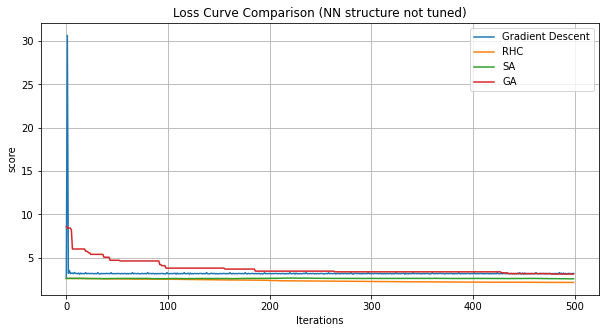

In [ ]:
plt.title("Loss Curve Comparison (NN structure not tuned)")
plt.xlabel("Iterations")
plt.ylabel("score")
x= np.arange(min(len(sa_nn_baseline.fitness_curve), len(rhc_nn1.fitness_curve), len(sa_nn0.fitness_curve),len(ga_nn0.fitness_curve)))

plt.plot(x, sa_nn_baseline.fitness_curve *-1, label="Gradient Descent")
plt.plot(x, rhc_nn1.fitness_curve[:,0], label="RHC")
plt.plot(x, sa_nn0.fitness_curve[:,0], label="SA")
plt.plot(x, ga_nn0.fitness_curve[:,0], label="GA")

plt.legend(loc="best")
plt.grid()
plt.show()

## Tuned NN structures

###baseline: sa_nn_baseline14 (0.5039)
###RHC:rhc_nn5 (0.4841642939997891)
###SA:sa_nn9 (0.4809585574185384)
###GA:ga_nn4 (0.4511272803964991 )

In [37]:
len(sa_nn_baseline13.fitness_curve)

23

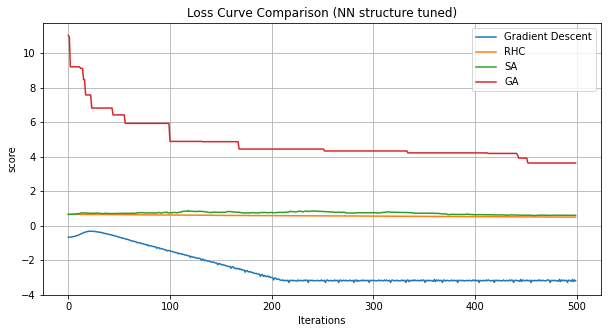

In [34]:
plt.title("Loss Curve Comparison (NN structure tuned)")
plt.xlabel("Iterations")
plt.ylabel("score")
#x= np.arange(min(len(sa_nn_baseline9.fitness_curve), len(rhc_nn5.fitness_curve), len(sa_nn9.fitness_curve),len(ga_nn4.fitness_curve)))
x=np.arange(500)

plt.plot(x, sa_nn_baseline10.fitness_curve[:500], label="Gradient Descent")
plt.plot(x, rhc_nn5.fitness_curve[:,0][:500], label="RHC")
plt.plot(x, sa_nn9.fitness_curve[:,0][:500], label="SA")
plt.plot(x, ga_nn4.fitness_curve[:,0][:500], label="GA")

plt.legend(loc="best")
plt.grid()
plt.show()

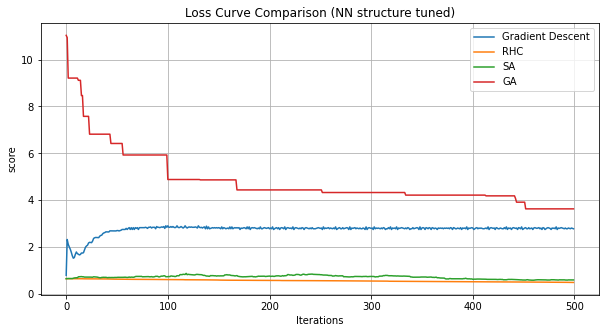

In [20]:
plt.title("Loss Curve Comparison (NN structure tuned)")
plt.xlabel("Iterations")
plt.ylabel("score")
#x= np.arange(min(len(sa_nn_baseline9.fitness_curve), len(rhc_nn5.fitness_curve), len(sa_nn9.fitness_curve),len(ga_nn4.fitness_curve)))
x=np.arange(500)

plt.plot(x, sa_nn_baseline14.fitness_curve[:500] *-1, label="Gradient Descent")
plt.plot(x, rhc_nn5.fitness_curve[:,0][:500], label="RHC")
plt.plot(x, sa_nn9.fitness_curve[:,0][:500], label="SA")
plt.plot(x, ga_nn4.fitness_curve[:,0][:500], label="GA")

plt.legend(loc="best")
plt.grid()
plt.show()